<img src="imgs/logo.png" width="100%">
-----

# Probabilistic filtering for intention inference

#### Inferring user intention in a noisy world
----

    All theorems are true. 
    All models are wrong. 
    And all data are inaccurate. 

    What are we to do? 
    We must be sure to remain uncertain.

-- *[Leonard A. Smith, Proc. International School of Physics ``Enrico Fermi", (1997)](http://www2.maths.ox.ac.uk/~lenny/fermi96_main_abs.html)* 

In [1]:
# import the things we need
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pykalman
import ipywidgets
import IPython
import matplotlib, matplotlib.colors
matplotlib.rcParams['figure.figsize'] = (14.0, 8.0)
%matplotlib inline
from scipy.stats import norm
import scipy.stats

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
OutputArea.prototype._should_scroll = function(){return false};

<IPython.core.display.Javascript object>

# Introduction 

-----------------

## Outline for section B: Probabilistic filtering for intention inference
We will:

### Part I
* <a href="#inference"> Show how to represent interaction problems as inference and discuss how probabilistic filters can be used to attack these inference problems </a>
* <a href="#alternatives"> Discuss *alternative* approaches to solving interaction problems </a>
* <a href="#principles"> Discuss principles behind probabilistic tracking of belief </a>

* <a href="#terminology"> Introduce the basic terminology for probabilistic filters</a>
* <a href="#noisycursor"> Experiment with *noisy cursors* </a>
* <a href="#cursormodel"> Model the cursor problem probabilistically </a>

* <a href="#kalman"> Discuss the Kalman filter and its assumptions </a>
* <a href="#kalmantest"> Build and run a simple Kalman filter on offline static data </a>


* <a href="#practical"> **Practical**: build an online Kalman filter to  recover corrupted cursor input probabilistically </a>

### Part II
* <a href="particle_gesture.ipynb#gesture"> Introduce the gesture recognition problem</a>

* <a href="particle_gesture.ipynb#kalmanlitations"> Discuss the limitations of the Kalman filter</a>

* <a href="particle_gesture.ipynb#particle"> Introduce the particle filter as a general probabilistic filter. </a>
* <a href="particle_gesture.ipynb#sinewave">Visualise the particle filter tracking a simple 1D function </a>

* <a href="particle_gesture.ipynb#phaserecovery">Show how the particle filter  can infer hidden variables </a>

* <a href="particle_gesture.ipynb#gesturemodel">Write the gesture spotting and recognition task in a form amenable to particle filtering </a>

* <a href="particle_gesture.ipynb#challenge"> **Challenge**: build a working 2D mouse gesture recogniser using a particle filter </a>

---

### What will we *practically* do?
* **Part I**: We will build a model that can track and predict cursor location using a **Kalman filter**, even as noise levels increase and observations become intermittent.

* **Part II**: We will build a 2D mouse gesture recognizer using a hybrid discrete/continuous **particle filter**. This will be a simple, robust classifier with rich feedback opportunities.




------

<a id="inference"> </a>
#### Interaction as inference
One view on interaction is to see user intentions as **unknown values** which are partially observed through input sensors. The time series of inputs from the user only give a partial, noisy, incomplete view of intention inside the user's head. 

Probabilistic filtering **(PF)** tracks the evolution of some unknown variables *[user intentions]* given observed evidence *[user input]*, in a way that is **robust**. Probabilistic filters infer a **distribution** over possible hidden (unobserved) variables, updating them over time. These filters are inherently **uncertain**, as they represent degrees of belief, and **dynamic**, as they explicitly model changing state over time.

<img src="imgs/brain_inference.png">


#### Simulation viewpoint
These filters are really *simulators*. They *simulate* how possible user behaviors might unfold over time. In some probabilistic filters, hundreds of parallel simulators are run, each with slightly different parameters. In all cases, the simulations are adjusted online to better match observed reality. The internal parameters that drive the simulation are the *unknown variables* we want to infer and the *evidence* is the observed reality that adjusts the simulation parameters.

#### Properties
Probabilistic filtering is:

| Property | Why  |
|----------|------|
|**Bayesian**  |  Represents degrees of belief using probability distributions.    |
|**predictive**  |  Works by comparing predictions with reality.   |
|**generative** |  Involves generating (i.e. simulating) behavior.   |

-----
Probabilistic filtering is an **inverse probability** approach, and it requires that we think of interaction from an unique perspective. We have to explicitly be able to write down:

* what we want to know (i.e. the **state space of intention**);
* how that will change over time (i.e. the **dynamics of intention**);
*  a model that *if we knew what the user intention was, what the expected behavior would be* (i.e. a **generative function mapping intention -> expected user inputs**).

Note that this last point is the **inverse** of the typical way of approaching this problem, where we would try and find a mapping from a sensors to intention, by design or by learning. 

### Why is this computational HCI?
Probabilistic filtering means writing down an **executable, statistical model** of user behavior, then **running an inference algorithm** that updates beliefs based on the way observations evolve. The **parameters** of the filter can be **learned from user data**. The effectiveness of the filter can be quantitatively measured.

<a id="alternatives"> </a>
### What are competitive approaches?
#### **Crafted mappings**
**where we try to find (by hand) transforms from sensors to intentions that are  simple or obvious.**

**Example:** a button, which has two physical states, and maps on to two intentional states via two electrical states. Pushed down = current flows = user intended to switch on. The mapping from electrical states to intentional states is **designed.**
<img src="imgs/undo.jpg">
*[Image credit: David Singleton via flickr.com CC-BY 2.0]*

#### **Machine learned mappings**
**where we train a system to recognize a class of input patterns as being representative of an intended behavior. **
**Example:** Finger gesture recognizer; hundreds of examples of many users performing one of N multi-touch gestures are recorded. These are used to train a random forest to classify the intended gesture. The mapping from electrical states (capacitive sensors) to intentional states is **learned**.

<img src="imgs/svm.jpg" width="300px">
*[Image credit: Elisfm - via Wikimedia Commons; public domain]*

### Benefits
* **Robustness to noise** PFs work well even with input sensors that are noisy.
* **Robustness to poorly specified models** PFs can cope predictably even if our models are bad.
* **Robustness to intermittence** PFs can continue to sensibly interpolate when input cuts out.
* **Uncertainty estimates** PFs *know how certain they are* and this can be used in the interaction design.
* **Decoupled from real-time** PFs can infer past (smoothing), present (filtering) and future (forecasting).
* **Inherent fusion of multiple input sensors** PFs are often used to solely to fuse together multiple inputs from different sensors.
* **Better feedback** PFs  offer the opportunity to give users rich insight into the process of intention decoding.
* **Flexible modeling** PFs can incorporate both fundamental modeling (e.g. physiological or cognitive models) and data-driven machine learning.

<a id="principles"> </a>
# Principles 
-------

> Interaction is the process of driving a system into a state compatible with user intentions.

There are many perspectives on interaction from this stance, including:

| Perspective   | Burden | Characteristic                         |
|---------------|--------|----------------------------------------|
| Communication | User   | User gets information into the system, by encoding intentions. |
| Control       | Split  | User drives state towards intention via feedback control.   |
| Inference     | System | System infers what user intention is from sensed user actions. |

### Interaction as inference
If we view interaction as inference of intention, there are three elements:
* **Interaction is inference**; it is the process of inferring a hidden variable: what the user wants a system to do. 
* **Observations are noisy and incomplete** What a system sees is a distorted and incomplete representation of user actions in the world, which are in turn a noisy representation of internal intentions (your hand does not always go where you want it...)
* **Interaction occurs over time** Interaction is a *process* that evolves over time. Information flow is not instantaneous.

<img src="imgs/brainspace.png" width="100%">

### Overview diagram



<img src="imgs/control_loop.png">

<a id="terminology"> </a>
## Terminology 

Notation:
* We have a sequence of states over time, indexed by $t$
* $X_t$ the variable we want to know (at time $t$) (e.g. an intention inside a user's head). 
* $Y_t$ the variable we can observe (e.g. a sensor we can get readings from).
* For computational simplicity, we assume **discrete time**, i.e. we observe sensors in a discrete, regularly sampled way.

* We want to compute $P(X_t|Y_t)$ (the **inverse problem**). 
* We use a **forward model** $P(Y_t|X_t)$ to infer this.
* We need to define two functions: ${\bf\hat{y_t}} = f({\bf \hat{x}}_t)$ (the **observation function**) and $\hat{\bf x}_{t} = g(\hat{\bf x}_{t-1})$ (the **dynamics** or **process function**).
* We also need to compute the likelihood of the real observation given our model: $p(\bf\hat{y_t}|{\bf y_t})$.


* $f$, $g$ are often very simple functions.

<img src="imgs/stochastic.png" width="75%">


#### Recursive filtering

<img src="imgs/recursive.png" width="70%">

Probabilistic filters are sometimes called **recursive Bayesian filters**. 
* They are **Bayesian** because they represent belief about states via probability distributions.
* They are **recursive** because they take a *prior*, condition on *evidence* and compute a *posterior*; this *posterior* then becomes the *prior* at the next time step.

As well as straightforward conditioning on observed evidence, probabilistic filters incorporate dynamics which form predictions of the world at the next time step.

#### Predictor-corrector
**This is a predictor-corrector model**; the dynamics model supplies predictions, and corrections to those predictions are applied by the observation model.


## The problem
**We want to track the position of a cursor; a 2D point under the control of a user.**

We will take the case of a mouse (or touchpad). A mouse is usually very reliable and outputs data that is easy to reconstruct into a cursor trajectory; just integrate up the average flow vector seen by the optical sensor.



We will simulate some of the issues that might happen with less reliable sensors, such as tracking an object with a camera-based system. This means we might encounter: 
* **noise**: continuous random variations in the measured position
* **dropout**: complete loss of measurement or tracking
* **glitches**: random spikes of sensing that are not due to intentional movement (e.g. when the camera has a false recognition and the tracking suddenly jumps).

<a id="noisycursor"> </a>
## The cursor problem
We will use a simple simulator which will corrupt mouse input with these different sources of noise, and also allow us to apply processing to the position signal to attempt to restore the intended position.

In [1]:
from noise_cursor import NoiseCursorDemo

In [2]:
# no noise
n = NoiseCursorDemo()        
%gui tk

Exiting...
Hit 0/0 targets in 1.0 seconds
Hits per second: 0.000
Error in quit routine; exiting anyway


In [ ]:
# some noise
n = NoiseCursorDemo(noise=20)        
%gui tk

## Why not just smooth things with a simple linear filter?

Since the *intentional* signal is low-frequency, and the noise is distributed throughout all frequencies, we can use a linear filter to separate the intentional component from the noise component. 

In practice, for high noise levels, there is tradeoff between noise reduction and *lag* in the response of a system. Rejecting of noise comes at the cost of reduced responsiveness.

A very simple linear filter is:
$$y_n = \alpha y_{t-1} + (1-\alpha)x_{t},$$
with input at each time $x_t$ and output $y_t$.

This is an *infinite impulse response* (IIR) filter, sometimes called the exponential smoother. The parameter $\alpha$ determines the level of filtering; as it approaches 1.0 the filter cutoff drops lower and lower. 


In [3]:
# Creates a simple one-pole IIR smoothing filter,
# with a cutoff set by alpha (closer to 1 is more extreme filtering)
def mk_lowpass(alpha):
    state = [0,0]
    def update(x,y):
        if x==x and y==y: # nan test
            state[0] = alpha*state[0] + (1-alpha)*x
            state[1] = alpha*state[1] + (1-alpha)*y
        return list(state)
    return update
    


In [5]:
# apply filtering to the cursor output
n = NoiseCursorDemo(filter=mk_lowpass(alpha=0.97), noise=30)        
%gui tk

Exiting...
Hit 1/1 targets in 7.5 seconds
Hits per second: 0.134
Hit rate: 1.000


### Spike noise
This isn't a bad solution for Gaussian noise. But when we start to encounter disturbances beyond simple noise, the linear filter begins to break down. For example, jump (spike) noise that we might see when a tracker temporarily locks on to a false target. This causes spikes in the signal that cannot be removed by linear filtering; they just get smoothed out into long excursions.

In [6]:
# and some mistracks
n = NoiseCursorDemo(filter=mk_lowpass(alpha=0.95), noise=30,   
                    jump=0.05, jump_scale=5000)        
%gui tk

Exiting...
Hit 0/0 targets in 10.8 seconds
Hits per second: 0.000
Error in quit routine; exiting anyway


### Signal dropout
If we now experience signal dropout, then we have the problem that the cursor freezes in place (or disappears entirely if we have a particularly poorly implemented system).

This kind of distortion is common with cursor estimation based on object recognition, where failure to recognise the object means that no updates to the cursor can be made.

In [7]:
# add some tracking losses
n = NoiseCursorDemo(filter=mk_lowpass(alpha=0.95), noise=30,  
                    jump=0.05, jump_scale=5000,
                    dropout=[0.04, 0.1])        
%gui tk

Exiting...
Hit 0/0 targets in 7.8 seconds
Hits per second: 0.000
Error in quit routine; exiting anyway


## Maybe we need a better filter?
The 1Euro filter, from [Casie et. al (CHI 2012)](http://cristal.univ-lille.fr/~casiez/acm.php?id=N05397) is an adaptive (nonlinear) filter for noisy cursor tracking.

It uses a simple one-pole IIR filter as above, but it can dynamically adjust $\alpha$ based on an estimation of the noise and the velocity of the cursor. This allows it to filter more heavily when noise is high and the cursor is relatively slow, and be more responsive during fast cursor movement or where noise reduces.

In [8]:
from oneeurofilter import OneEuroFilter

# make a 2D OneEuroFilter function
def mk_oneuro(*args, **kwargs):
    # state, which is propagated from time step to time step
    filters = [OneEuroFilter(*args, **kwargs),OneEuroFilter(*args, **kwargs)]
    state = [0,0]
    def update(x,y):
        if x==x and y==y: # nan test
            state[0] = filters[0](x)
            state[1] = filters[1](y)            
        return list(state)
        
    return update

In [16]:
# The one-euro filter has two critical parameters: mincutoff and beta, which set
# the limit on alpha and the responsiveness adjustment rate, respectively
# it works very well for variable velocity problems, which are very common in cursor tracking
# type problems
n = NoiseCursorDemo(filter=mk_oneuro(freq=1.0, mincutoff=0.01, beta=0.0008), noise=30)

Exiting...
Hit 2/2 targets in 3.7 seconds
Hits per second: 0.534
Hit rate: 1.000


In [17]:
# but with dropout and mistracks, the one euro filter starts to struggle
n = NoiseCursorDemo(filter=mk_oneuro(freq=1.0, mincutoff=0.001, beta=0.001), noise=30, 
                    jump=0.05, jump_scale=5000, 
                    dropout=[0.04, 0.1])        
%gui tk

Exiting...
Hit 0/0 targets in 0.9 seconds
Hits per second: 0.000
Error in quit routine; exiting anyway


## Thoughts
These various ad hoc signal processing approaches can clean up some forms of noise. But they struggle to track the cursor well with very degraded sensing. A more principled approach can do a better job -- by *representing and propagating uncertainty*.

---------------

<a id="cursormodel"></a>
## The task
We want to recover the **intended position** of the cursor from the observed sensing.

* That is, we have $\bf x_t$ be the **intended position** of the cursor at $t$ (this is the hidden variable we wish to estimate). The intended position exists in the user's head. We *infer* it from our observations.

* We have $\bf y_t$, the observation made at time $t$, which might be the displacement vector the OS reports in our example, or a reported position, or a flow vector from a camera and so on. 

----
To do proper modelling, we need to write down our problem explicitly. This might seem overkill for the cursor problem (can't we just throw in some extra signal processing), but a principled approach allows us to do the *right* thing and understand the assumptions that have been made.

----

* **State space for $\bf x_t$**. $\bf x_t$ is our belief about intended location. It obviously has at least two coordinates giving an intended location in screen space. But we can do a better job at predicting motion if we assume some predictable smooth *dynamics* of the cursor. In particular, we can assume that there is some associated **velocity** and **acceleration** of the cursor, and at each time point time, ${\bf x_t} = [x_t, y_t, \dot{x}_t, \dot{y}_t, \ddot{x}_t, \ddot{y}_t]$.
($\dot{x}$ means the first time derivative of $x$, $\ddot{x}$ means the second time derivative of $x$).
Note that, like in al Bayesian modelling, we assume some distribution over possible values of $\bf x_t$, and update that belief using Bayes' Rule. It is important to note that we have a state space that includes variables we will never make observations for (velocity, acceleration), but which yet can be tracked by the filter.

* **State space for $\bf y_t$** $\bf y_t$ is given by our sensor configuration. The OS reports two positions  , $mx_t$ and $my_t$ at each observation. 
So ${\bf y_t} = [ mx_t, my_t ]$. Because observations can be subject to uncertainty (they do not report the world authentically), we again assume some distribution over ${\bf y_t}$. This is not updated (typically); we merely state our estimated level of belief in the observations as a distribution.

* **Prior** *where would we believe the cursor to be if we had made no measurement? $p({\bf x_0})$*
Bayesian inference always requires a prior. In our case, we are doing recursive filtering, so the posterior for one step is the prior for the next. But we need to have a prior for the very *first* step to do anything meaningful. 
We can assume the cursor is intended to be somewhere on screen. Beyond that, we might not have any guesses as to where the cursor might be. We could be clever and assume that the cursor is likely to be near targets of interest (e.g. close to menu headers), but for now, we will assume a simple normal prior on position, velocity and acceleration.


These give us the groundwork for defining the problem. We then need to consider how the update process that takes us from prior to posterior via evidence will work at each time step.

We assume some *known dynamics* (i.e. a predictor) along with a model linking our state space to our observations, and a way of evaluating real observations given predicted ones (likelihood):

* **Dynamics** *given a current estimate of intended position, where would we expect the next intended position to be?*
We would assume that the cursor is near where it was, but is moving smoothly some velocity and acceleration: after all, it is the result of a physical motion in the world and thus has second-order dynamics.
This is the **transition function** $f(\bf{x_t})$ in ${\bf x_{t+1}} = f({\bf x_t}) + \epsilon$
$\epsilon$ is an error term that models our belief that the dynamics are only an approximation and that the true state will diverge from this.

* **Observation** *given our estimate of intended position, what observations would we expect?*
We'll assume that the velocity of the cursor gives us the frame-by-frame mouse position. The observation is assumed to be a noisy representation of the true position. We have to write a function that takes us from the *hidden state spac* to the *observed state space* **not the other way around!**. This is the **observation function** $g({\bf x_t})$ in $\hat{\bf y_t} = g{\bf x_t} $. 

* **Likelihood** given an observation, how probable is it compared to our expected observations? This is the likelihood function $P({\bf y_t}|{\bf x_t}) = P({\bf y_t}|{\bf \hat{y_t}})$

<a id="kalman"> </a>
## The Kalman filter
### Assumptions
We are going to model the distribution of possible states in our state space for ${\bf x_t}$, updating this over time with observations that are made ${\bf y_t}$ to compute the next step. 

The Kalman filter lets us do this very efficiently, as long as we can make some fairly strong assumptions about the form of uncertainty and the type of dynamics we expect to see.

We will omit most of the mathematical mechanics of the Kalman filter, which often looks pretty gory, but is actually fairly straightforward.

#### Normality of all distributions
The Kalman filter approximates all distributions as multivariate normal (Gaussian) distributions.

This includes:
* the *process noise*, i.e. the stochastic part $\epsilon$ of the dynamics (how much the state "blurs" out on each time step)
* the *observation noise*, i.e. the noise in the observation process (how "blurred" the observation is)
* the distribution over the current *state* of the filter (how "blurred" the current belief is)
* the *likelihood* of the observation given the current state, which is just the distribution of the the state transformed into the observation space.

All of these are Gaussian and characterised by a **mean** (location) $\mu$ and a **covariance matrix** $\Sigma$ which specifies the shape of the distribution; it can be seen as defining the shape of the ellipsoidal isosurfaces of the distribution.

In [ ]:
## A selection of different possible shapes of 2D Gaussians

def sigma_plot(sigma):
    mx = np.linspace(-5,5,40)
    x, y = np.meshgrid(mx,mx)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = scipy.stats.multivariate_normal([0,0], sigma)
    plt.contourf(x, y, rv.pdf(pos))

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sigma_plot([[1,0], [0,1]])    
plt.title("Unit variance, square")
plt.subplot(2,2,2)
sigma_plot([[0.25,0], [0,0.25]])    
plt.title("Smaller variance, square")
plt.subplot(2,2,3)
sigma_plot([[2,0], [0,0.5]])    
plt.title("Unequal variance")
plt.subplot(2,2,4)
plt.title("Skewed")
sigma_plot([[6,0], [1.2,0.4]])    
plt.suptitle("Various covariance matrices for a 2D Gaussian")    

#### Linearity of dynamics
The Kalman filter, in its basic form, also assumes that all dynamics are **linear**. That is, our next guess of ${\bf x_{t+1}} = A{\bf x_t};$ the transformation function $f(\bf{x_t})$ from the previous state to the next must be expressible as a simple matrix multiplication.

We will assume discrete time, i.e. that we make discrete steps from one time point to the next, and our dynamic system is a function that maps from one point in the state space to a new point at the next time step.

For example, basic second-order dynamics of a point can be written as a discrete time linear system:

$$X_t = [x_t, \dot{x_t}, \ddot{x_t}]$$
$$A = \begin{bmatrix}
1 & \Delta T & \frac{1}{2}\Delta T^2\\
0 & 1& \Delta T\\
0 & 0& 1\\ 
\end{bmatrix}$$
$$X_{t+1} = A{\bf x_t}$$

Note that the Kalman filter does not require $A$ to be the same at each timestep; we can have a time-varying $A_t$ which is different at each time step. This can be used to **locally** linearise a system with nonlinear global dynamics (i.e. to use a new linear approximation at each new timestep).

#### Linearity of observations
Additionally, the mapping described by $g({\bf x_t})$ which takes ${\bf x_t} \rightarrow {\bf y_t}$ must also be linear, and described by a matrix $C$. Given a $d_x$-dimensional state and a $d_y$ dimensional observation space,  $C$ is a $d_x \times d_y$ matrix.

## Why?
These restrictions seem quite limiting, but the problem with maintaining probabilistic state is that the density/mass functions could be arbitrary; and there are no direct ways to manipulate such arbitrary functions. The **linear Gaussian** model avoids this by using these remarkable properties of Gaussian functions:

* every *linear transformation* of a Gaussian is Gaussian (therefore any predictive model that can be written as a linear transform can be used to generate a new Gaussian predictive distribution, and Gaussian distributions can be freely transformed to/from observation and state space.), 
    * Applying the transformation $Ax+b$ to a multivariate Gaussian parameterised by $\mu, \Sigma$ results in a new Gaussian with parameters $\mu^\prime = A\mu+b, \Sigma^\prime = A\Sigma A^T$.    
* the *convolution of two Gaussians* is Gaussian, (so adding Gaussian uncertainty to a Gaussian distribution remains a Gaussian),
    
(see [this page](http://www.tina-vision.net/docs/memos/2003-003.pdf) for details on the mathematics for products and convolutions of multivariate Gaussians, or the excellent [Matrix Cookbook](http://compbio.fmph.uniba.sk/vyuka/ml/old/2008/handouts/matrix-cookbook.pdf) which lists numerous such useful formulae) 

As a consequence, the Kalman filter can maintain the full probabilistic state and perform all of its updates just by updating the parameters of a multivariate Gaussian which represents our belief in the state space of $\bf{x_t}$ (a mean vector $\bf \mu$ and covariance matrix $\Sigma$). 

This is very computationally and inferentially efficient: it is quick to do, and the estimates can be very good even with limited data, *as long* as the problem at hand is reasonably modeled with these assumptions.

<a id="kalmantest"> </a>
# Building a cursor Kalman filter

### Dynamics

Let's first assume we only have a 2D position, velocity and acceleration, so our state space is $[x_t, y_t, \dot{x}_t, \dot{y}_t, \ddot{x}_t, \ddot{y}_t]$, and we can write some simple second order dynamics:

$$A = \begin{bmatrix}
1 & 0 & \Delta T & 0 & \frac{1}{2}\Delta T^2 & 0 \\
0 & 1 & 0 & \Delta T & 0 & \frac{1}{2}\Delta T^2  \\
0 & 0 & 1 & 0 & \Delta T & 0\\
0 & 0 & 0 & 1 & 0 & \Delta T\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
\end{bmatrix}$$

These dynamics are *generic* and are not special to cursor trajectory estimation. For many 2D second-order systems, this matrix is usable as is; more complex dynamics might be involved where problems have stat variables beyond simple 2D movement (e.g. the Speed Dependent Automatic Zooming formulation given in [Eslambolchilar 2003](http://eprints.gla.ac.uk/13684/)).

We also assume that our dynamics have some **noise**; i.e. they are not fully deterministic. We can predict the future, but not exactly. 

By the restrictions of the Kalman filter, this must be Gaussian (normally distributed noise), and it has a structure given by a **covariance matrix** $\Sigma_A$. We need to **specify** this covariance matrix (note that it can be *learned from data* as well).

We will assume the noise is uncorrelated, and is equal across $x$ and $y$, so the covariance looks like a diagonal matrix:

$$\Sigma_A = \begin{bmatrix}
\sigma_x & 0  & 0 & 0  & 0 & 0 \\
0 & \sigma_x  & 0 & 0  & 0 & 0 \\
0 & 0  & \sigma_{dx} & 0  & 0 & 0 \\
0 & 0  & 0 & \sigma_{dx} & 0 & 0 \\
0 & 0  & 0 & 0 & \sigma_{ddx} & 0 \\
0 & 0  & 0 & 0 & 0 & \sigma_{ddx} \\
\end{bmatrix}$$

and our whole dynamics equation is then just:

$$X_{t+1} = A{\bf x_t} + N(0,\Sigma_A) $$

(the transformation given by $A$ followed by some extra Gaussian uncertainty, specified by $\Sigma_A$).

We can write this in code:

In [20]:
sigma_x = 1
sigma_dx = 0.1
sigma_ddx = 0.001
sigma_a = np.diag([sigma_x, sigma_x, sigma_dx, sigma_dx, sigma_ddx, sigma_ddx])

dt = 0.5 # 1 / frame rate in some time units
dt2 = 0.5 * dt * dt
A = np.array([
             [1,0,  dt,0, dt2,0],
             [0,1,  0,dt, 0,dt2],
             [0,0,  1,0,  dt,0],
             [0,0,  0,1 , 0,dt],
             [0,0,  0,0,  1, 0],
             [0,0,  0,0,  0, 1]])
print(sigma_a)
sigma_a *= 0.01
print(A)

[[ 1.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.   ]
 [ 0.     0.     0.1    0.     0.     0.   ]
 [ 0.     0.     0.     0.1    0.     0.   ]
 [ 0.     0.     0.     0.     0.001  0.   ]
 [ 0.     0.     0.     0.     0.     0.001]]
[[ 1.     0.     0.5    0.     0.125  0.   ]
 [ 0.     1.     0.     0.5    0.     0.125]
 [ 0.     0.     1.     0.     0.5    0.   ]
 [ 0.     0.     0.     1.     0.     0.5  ]
 [ 0.     0.     0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.     1.   ]]


Since this is predictive (generative) model of how we expect the cursor to behave, we can try running the prediction, starting from some preset initial conditions. If our dynamics model is good, we should expect the trajectories generated to be something (vaguely!) like cursor motion:

In [21]:
def simple_simulate_dynamics(A, sigma_a, x=None, n=100):
    # given update matrix A and noise matrix sigma_a, produce a trajectory
    # using the Kalman filter prediction equations
    # start from all zero conditions
    if x is None:
        x = np.zeros((A.shape[0],))
    xs = []
    for i in range(n):
        # apply update rule
        # x_{t+1} = A x_t + N(0, sigma_a)
        x = np.dot(A,x) + scipy.stats.multivariate_normal.rvs(cov=sigma_a)
        xs.append(x)
    return np.array(xs)

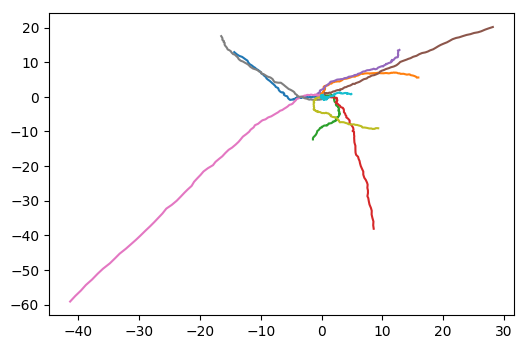

In [22]:
# run 10 random walks  with these dynamics
def trajectory_realisations(A, sigma_a, n=100, walks=10):
    for i in range(walks):
        xs = simple_simulate_dynamics(A, sigma_a)
        plt.plot(xs[:,0], xs[:,1], '-', markersize=2)
        
trajectory_realisations(A, sigma_a)

## Alternative dynamics (changing $\Sigma_a$)
We can postulate alternative dynamics, and observe the effect

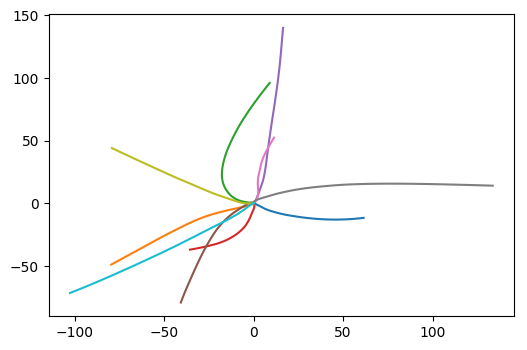

In [23]:
# Just acceleration; smooth trajectories
sigma_a2 = np.diag([0.0, 0.0, 0.0, 0.0, 2e-4, 2e-4])
trajectory_realisations(A, sigma_a2)

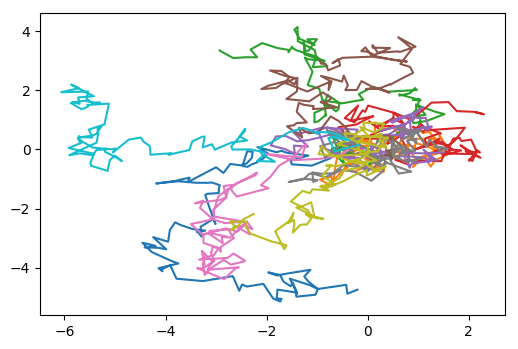

In [24]:
# no acceleration, no velocity noise, just position noise

sigma_a3 = np.diag([0.05, 0.05, 0 , 0, 0, 0])
trajectory_realisations(A, sigma_a3)

## Observations
We need to be able to transform our internal state $\bf {x_t}$ into the observation we would expect to see given that state. (NB: **not** to translate our observation into our state space!)

In this case, we assume that we'd expect to see a position equal to the position term of our state. We can again write this as a matrix $C$ (i.e. a linear projection from our internal state space to the observation):

$$C = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0\\
\end{bmatrix}$$

This just says we transfer the position to the output space, ignoring the velocity and acceleration components of $\bf{x_t}$.



In [25]:
C = np.array([[1,0,0,0,0,0], 
              [0,1,0,0,0,0]]).astype(np.float64)
print(C)

[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]]


We also know that our observation is **noisy** (i.e. not a true measurement of the world).
We can (again) use a Gaussian to represent the noise we expect to see, characterised by a covariance $\Sigma_c$. The following diagonal matrix assumes noises is equal on $x$ and $y$ and uncorrelated, i.e. our Gaussian has a spherical form.

$$\Sigma_C = \begin{bmatrix}
\sigma_c & 0 \\
0 & \sigma_c \\
\end{bmatrix}$$

In [26]:
sig_c = 15
sigma_c = np.diag([sig_c, sig_c])
print(sigma_c)

[[15  0]
 [ 0 15]]


The complete equation for the observations is:
$${\bf\hat{y_t}} = C {\bf x_t} + N(0, \Sigma_C)$$

## Prior
We assume that the initial guess will put the cursor somewhere on the screen, with possibly a small velocity and a smaller still acceleration. Given coordinates for the centre of the screen $x_c, y_c$, we can write this as as $${\bf{x_0}} \sim [N(x_c,x_c/2), U(y_c,y_c/2), N(0, \sigma_v), N(0, \sigma_v), 
N(0, \sigma_a), N(0,\sigma_a)]$$.

We have to be able to write this as a single multivariate Gaussian. We can rewrite this as ${\bf x_0} \sim N(\mu_0, \sigma_0)$, with:

$$\mu_0 = [x_c, y_c, 0, 0, 0, 0]$$
$$\sigma_0 = \begin{bmatrix}
x_c/2 & 0  & 0 & 0  & 0 & 0 \\
0 & y_c/2  & 0 & 0  & 0 & 0 \\
0 & 0  & \sigma_v & 0  & 0 & 0 \\
0 & 0  & 0 & \sigma_v  & 0 & 0 \\
0 & 0  & 0 & 0  & \sigma_a & 0 \\
0 & 0  & 0 & 0  & 0 & \sigma_a \\
\end{bmatrix}$$


In [27]:
xmax, ymax = 400, 400    # screen size
xc, yc = xmax/2, ymax/2  # coordinates of screen centre
mu_0 = np.array([xc, yc, 0, 0, 0, 0])
sigma_vel = 100
sigma_acc = 100
sigma_0 = np.diag([xc/2, yc/2, sigma_vel, sigma_vel, sigma_acc, sigma_acc])

## Creating the filter
We can now create a complete Kalman filter. We use the `pykalman` package to implement the filter mechanics. Note that the mathematical derivation of the Kalman filter looks pretty hairy, but is in fact relatively simple to implement; we won't go into the details here.

In [28]:
import pykalman

# create a filter with the parameters defined above
kalman_filter = pykalman.KalmanFilter(
    transition_matrices = A,
    observation_matrices = C,
    transition_covariance = sigma_a,
    observation_covariance = sigma_c,
    initial_state_mean = mu_0,
    initial_state_covariance = sigma_0
)
    

We can generate some synthetic data to track: in this case a parabolic curve, with some noise and portion of missing data.


In [48]:
# generate a simple parabolic trajectory, with a bit of noise and some missig
# observations
def gen_path(n):
    path = []
    cx, cy = 50,50
    t = 0
    for k in range(n):
        t+= 2.5
        # noise
        nx, ny = np.random.normal(0,3), np.random.normal(0,3)
        # drop out
        if k>35 and k<65:
            obs = [np.nan, np.nan]
        else:
            obs = [1.5*t+cx+nx,5*t-0.025*t*t+cy+ny]
        path.append(obs)
    return np.array(path)

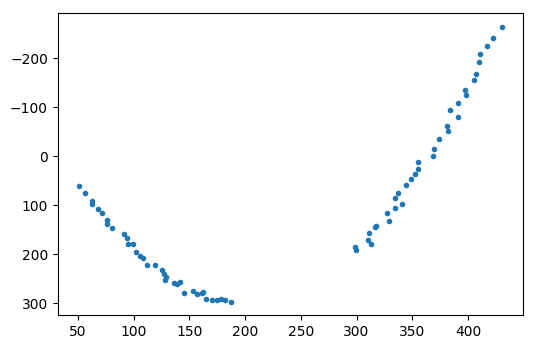

In [50]:
path = gen_path(100)
plt.plot(path[:,0], path[:,1], '.')
ax = plt.gca()
ax.invert_yaxis()


We can use the `filter_update()` function to compute new states as data comes in.

In [54]:
# filter-update example
mean, cov  = mu_0, sigma_0
for i in range(10):
    mean, cov = kalman_filter.filter_update(mean, cov, observation=path[i])
    print(mean[:2]) # x,y co-ordinates of mean
    

[ 66.61032421  75.30779133]
[ 51.50984317  68.725493  ]
[ 55.95491974  83.77168602]
[ 60.90982913  96.37888431]
[  68.1420355   109.22961524]
[  74.13063634  119.86412824]
[  79.98444016  132.86175366]
[  82.15011326  143.05010608]
[  85.54054686  151.71442243]
[  92.91125827  162.13232895]


In [ ]:
## Interactive animation
We can see the result at each step using this animation function:

In [60]:
# for interactive drawing
import kalman_utils
kalman_utils = reload(kalman_utils)
kalman_utils.run_kalman(path, mu_0, sigma_0, A, C, sigma_a, sigma_c)
         
%gui tk



Exiting...


## Rejecting observations
This filter does a very good job at reject Gaussian noise, and it can cope well when observations are missing. However, the "jump" noise we saw in the noisy cursor example, where spikes are introduced, is something the Kalman filter struggles with.

The filter will blindly follow these massive, sudden deviations and lead to very erratic control. We can see this if we slightly modify the path to have a few zero'd values:

In [63]:
glitch_path = gen_path(100)
glitch_path[::10,1] = 0 # every `10th y value set to zero
kalman_utils.run_kalman(glitch_path, mu_0, sigma_0, A, C, sigma_a, sigma_c, frame_time=20)
%gui tk        

Exiting...


But we can be cleverer. Because we can obtain the likelihood of any observation under our current model, we can simply ignore observations that appear to be too unlikely to be plausible.

<img src="imgs/likfilter.png" width="60%">

All we need to do is to measure the likelihood, compare it to some threshold, and treat the observation as missing if the value is too unlikely. This adjustment needs care: if we are too zealous in rejecting samples our filter may end up too far away from the observations to ever recover, for example if we *intentionally* moved the mouse very quickly.
But for the extreme, instantaneous jumps we are encountering, we can be fairly lax in choosing our likelihood threshold.

The code below in the practical section implements this, with a variable likelihood cutoff.

<a id="practical"> </a>
# Practical

Your task is to create a Kalman filter that does a good job tracking the noisy cursor, with these noisy cursor parameters:    

In [64]:
# The cursor before it has been filtered
test_cursor = NoiseCursorDemo(noise=30, 
                    jump=0.08, jump_scale=2000, 
                    dropout=[0.02, 0.15])        
%gui tk

NameError: name 'NoiseCursorDemo' is not defined

### Metric of success
Use hits per second as the criteria for (manual) optimisation. Adjust the parameterisation of the filter to get the best possible targeting performance.

## Skeleton code
The code below sets up the filter from scratch, but the *parameters* need to be configured to work well

In [65]:

# creates a new Kalman filter with the given parameters
def make_kf(A,sigma_a,C,sigma_C,mu_0,sigma_0,reject_lik=-np.inf):
    state = {"mean":mu_0, "cov":sigma_0}
    # construct the filter object
    kf = pykalman.KalmanFilter(transition_matrices = A, observation_matrices = C,
    transition_covariance = sigma_a,  observation_covariance = sigma_c,
    initial_state_mean = mu_0,    initial_state_covariance = sigma_0)
    
    def update(x,y):
        # project state into obsevation space, so we can compute
        # the log-likelihood of observations directly
        pred_obs_mean = np.dot(C, state["mean"])
        pred_obs_cov = np.dot(C, np.dot(state["cov"], C.T))
        obs_arr = np.array([x,y])
        # likelihood of this sample
        lik = scipy.stats.multivariate_normal.logpdf(obs_arr, mean=pred_obs_mean, 
                                                     cov=pred_obs_cov)   
        # apply likelihood filtering
        if x==x and lik==lik and lik>reject_lik: # if x is not NaN
            mean, cov = kf.filter_update(state["mean"], state["cov"], observation=[x,y])
        else:
            # update without observation
            mean, cov = kf.filter_update(state["mean"], state["cov"])
        state["mean"] = mean        
        state["cov"] = cov  
        # return the various parameters
        return {"mean":[mean[0], mean[1]], "cov":cov[:2,:2], "lik":lik}
    return update
        



# Parameterisation

In [ ]:
## Modify this cell to adjust KF parameters

## Hints:
# adjust dt, sigma_a, sigma_c and reject_lik
# you can change A or C, but make sure you know what you are doing!
# changing mu_0 and sigma_0 probably won't have much effect, as the
# prior will be forgotten very quickly anyway

# A
dt = 1 # increasing this will speed up all dynamics, and vice versa
dt2 = 0.5 * dt * dt
A = np.array([[1,0, dt,0, dt2,0],
     [0,1, 0,dt, 0,dt2],
     [0,0, 1,0, dt,0],
     [0,0, 0,1, 0,dt],
     [0,0, 0,0, 1,0],
     [0,0, 0,0, 0,1]])

# sigma_A
sigma_x = 0.1
sigma_dx = 0.1
sigma_ddx = 0.1
sigma_a = np.diag([sigma_x, sigma_x, sigma_dx, sigma_dx, sigma_ddx, sigma_ddx])

# C
C = np.array([[1,0,0,0,0,0], 
              [0,1,0,0,0,0]]).astype(np.float64)
# sigma_C
sig_c = 1
sigma_c = np.diag([sig_c, sig_c])

# mu_0
xmax, ymax = 800, 800 # screen size
xc, yc = xmax/2, ymax/2  # coordinates of screen centre
mu_0 = np.array([xc, yc, 0, 0, 0, 0])

# sigma_0
sigma_vel = 1
sigma_acc = 1
sigma_0 = np.diag([xc/2, yc/2, sigma_vel, sigma_vel, sigma_acc, sigma_acc])

# rejection threshold for observations
# if you make this too close to zero (e.g. -5) all observations will be ignored
# if you make it too large, jumps will still get through
reject_lik = -10000

## Testing code

In [ ]:
#### Create the filter and run it
kfilter=make_kf(A,sigma_a,C,sigma_c,mu_0,sigma_0,reject_lik=reject_lik)

kalman_cursor = NoiseCursorDemo(filter=kfilter, 
                    noise=30, 
                    jump=0.05, jump_scale=5000,
                    dropout=[0.02, 0.15])        
%gui tk

# Thoughts on the Kalman filter

* If you had any trouble understanding this lecture, I **highly** recommend reading this outstanding blog post by Bzarg: [Kalman Filter in Pictures](http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/).


We've only scratched the surface of the Kalman filter. There are many other things that can be useful:
### Basic technical enhancements
* We can also introduce offsets (as well as linear transforms) to the dynamics and observations, in cases where there are constant shifts (i.e. to use $Ax+b$ and $Cx+d$ instead of $Ax$ and $Cx$).

* The Kalman filter can take a known *control* signal and use this in estimation (e.g. in a drone navigation system, where there is known human control input and an partially unknown dynamic system responding to this). This introduces a matrix $B$ to represent the control->state projection, and the state update becomes:
$$X_{t+1} = A{\bf x_t} + b + B{\bf u_t} +  N(0,\Sigma_a) ,$$
for a control input $\bf u_t$ at time $t$.
* All of the transform matrices A,B,C, and the covariances, $\Sigma_a, \Sigma_c$, can be changed at each timestep, so we have $A_t, B_t, C_t, \Sigma_{at}, \Sigma_{ct}$.

### Extending the filter
* The Kalman filter we used is "plain". It only supports linear dynamics. The **Extended Kalman Filter** changes the transition matrix at each time step, using a local linearisation of the dynamics. This, for example, can be useful if there are rotational and linear components in a model, where linear dynamics are a poor approximation to the whole system, but behaviour is close to linear for any given point in the state space.
* The **Unscented Kalman Filter** (so-called because it doesn't smell) goes even further, and allows any arbitrary dynamics to be applied. It uses a clever set of points drawn from the Gaussian distribution to characterise it. It passes points these through the dynamics/observation function, then reconstructs a new Gaussian from the transformed points. It is a stepping stone between the Kalman filter we discuss here, and the fully sample-based particle filter of the next section.
* Many applications use multiple Kalman filters in banks, either switching between different filters or tracking multiple discrete hypotheses. In the same we we rejected some samples, the likelihood can be used to select relevant filters in different operating conditions.

### Uncertainty
* We haven't even used the uncertainty we so carefully maintained. We still used a binary in/out test on the target for a point cursor. But we can use the whole distribution, and compute the probability that the target was intended (e.g. by integrating the posterior PDF over the target box).
* There are lots of interesting visualisations that can be used to reflect the system's uncertain belief back to the user and thus afford more stable control.

### Fusion
* The Kalman filter makes is very easy to fuse multiple sensors. Since we just need to write a transformation from the hidden state space to the observation space, if we have additional sensors we can just predict them as well, concatenating the observations onto the observation vector.  For example, if we had observed the total mouse velocity (perhaps with less noise) as well as the position, we could have used to improve our estimates.

* There is no special "fusion" step; it happens naturally. The Unscented Kalman Filter allows any arbitrary transform from the state space to the observation space (rather than just linear) and is particularly flexible for doing sensor fusion.


## [Link to Part II: Particle Filters for Gesture Recognition](particle_gesture.ipynb)